# Google Advanced Data Analytics Capstone: Providing data-driven suggestions for HR

### Import packages

In [48]:
pip install xgboost

In [49]:
# Import packages
# Operational packages

import numpy as np
import pandas as pd

# EDA and cleaning

import datetime as dt
import statsmodels.api as sm

# Logistic regression

from sklearn.linear_model import LogisticRegression


# Other ML Models

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import pickle

# Model evaluation

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Visualization packages

import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [50]:
df0 = pd.read_csv('Capstone data clean.csv')

# Viewing the first few rows of the dataframe
df0.head()

,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,left,recent_promotion,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 1. Data Exploration (Initial EDA and data cleaning)

### Gathering basic information about the data

In [51]:
# Gather basic information about the data
df0.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   satisfaction_level  11991 non-null  float64
 1   eval_score          11991 non-null  float64
 2   number_project      11991 non-null  int64  
 3   monthly_hours       11991 non-null  int64  
 4   tenure              11991 non-null  int64  
 5   work_accident       11991 non-null  int64  
 6   left                11991 non-null  int64  
 7   recent_promotion    11991 non-null  int64  
 8   dept                11991 non-null  object 
 9   salary              11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 936.9+ KB


### Gathering descriptive statistics about the data

In [52]:
# Gather descriptive statistics about the data
df0.describe(include = 'all')


,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,left,recent_promotion,dept,salary
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991,11991
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3239,5740
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929,NaN,NaN
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


### Renaming columns

In [53]:
# Display all column names
df0.columns


Index(['satisfaction_level', 'eval_score', 'number_project', 'monthly_hours',
       'tenure', 'work_accident', 'left', 'recent_promotion', 'dept',
       'salary'],
      dtype='object')

In [54]:
# Rename columns as needed
df0 = df0.rename(columns = {'promotion_last_5years' : 'recent_promotion',
                      'time_spend_company' : 'tenure',
                     'Department' : 'dept',
                     'average_montly_hours' : 'monthly_hours',
                     'last_evaluation' : 'eval_score', 'Work_accident' : 'work_accident'})

# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'eval_score', 'number_project', 'monthly_hours',
       'tenure', 'work_accident', 'left', 'recent_promotion', 'dept',
       'salary'],
      dtype='object')

### Checking for missing values

In [55]:
# Check for missing values
df0.any().isna().sum()


0

In [56]:
df0.isna().sum()

satisfaction_level    0
eval_score            0
number_project        0
monthly_hours         0
tenure                0
work_accident         0
left                  0
recent_promotion      0
dept                  0
salary                0
dtype: int64

### Checking for duplicates

In [57]:
# Check for duplicates
df0.duplicated().sum()


0

In [58]:
# Inspect some rows containing duplicates as needed
df0[df0.duplicated() == True].head()


,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,left,recent_promotion,dept,salary


In [59]:
df0[df0.duplicated() == True][['dept', 'salary', 'left']].value_counts()

Series([], dtype: int64)

In [60]:
# Dropping duplicates
df1 = df0.drop_duplicates()

### Checking for outliers

<Axes: xlabel='tenure'>

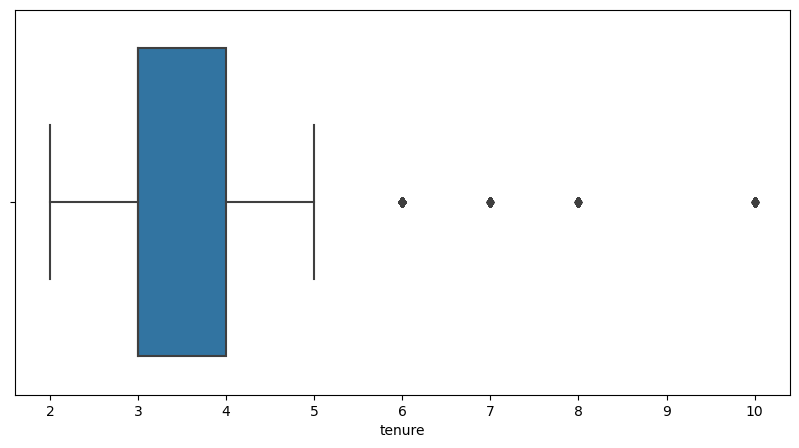

In [61]:
# Creating a boxplot to visualize outliers in the 'tenure' column
plt.figure(figsize = (10,5))

sns.boxplot(data = df1, x = 'tenure')



In [62]:
# Determining the number of rows containing outliers
df1[df1['tenure'] > 5].count()



satisfaction_level    824
eval_score            824
number_project        824
monthly_hours         824
tenure                824
work_accident         824
left                  824
recent_promotion      824
dept                  824
salary                824
dtype: int64

## 2. Data Exploration (Continue EDA)

In [63]:
# Getting numbers of people who left vs. stayed
print(df1['left'].value_counts())

# Getting the percentages of people who left vs. stayed
print(df1['left'].isin([1]).mean())

0    10000
1     1991
Name: left, dtype: int64
0.1660411975648403


### Data visualizations for variables of interest

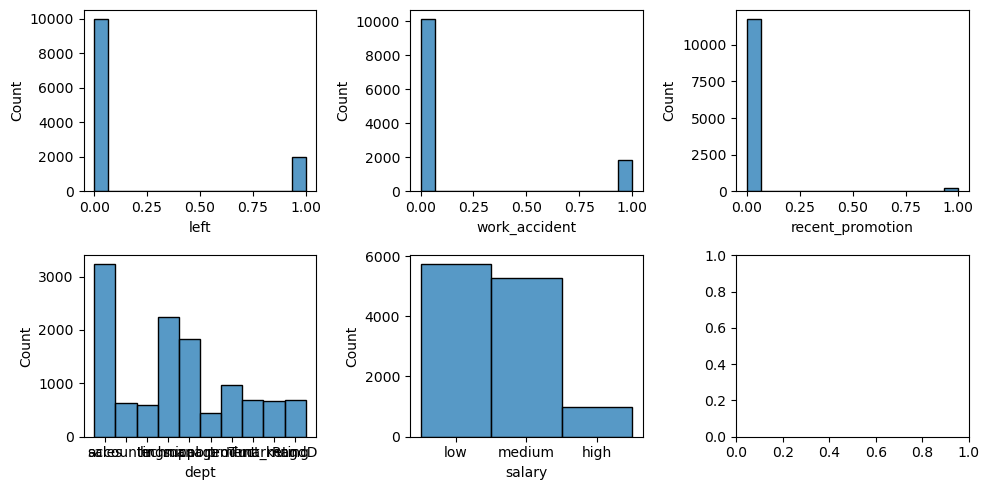

In [64]:
fig, axes = plt.subplots(2, 3, figsize = (10,5))

sns.histplot(data = df1, x = 'left', ax = axes[0,0])

sns.histplot(data = df1, x = 'work_accident', ax = axes[0,1])

sns.histplot(data = df1, x = 'recent_promotion', ax = axes[0,2])

sns.histplot(data = df1, x = 'dept', ax = axes[1,0])


sns.histplot(data = df1, x = 'salary', ax = axes[1,1])

plt.tight_layout()

plt.show()


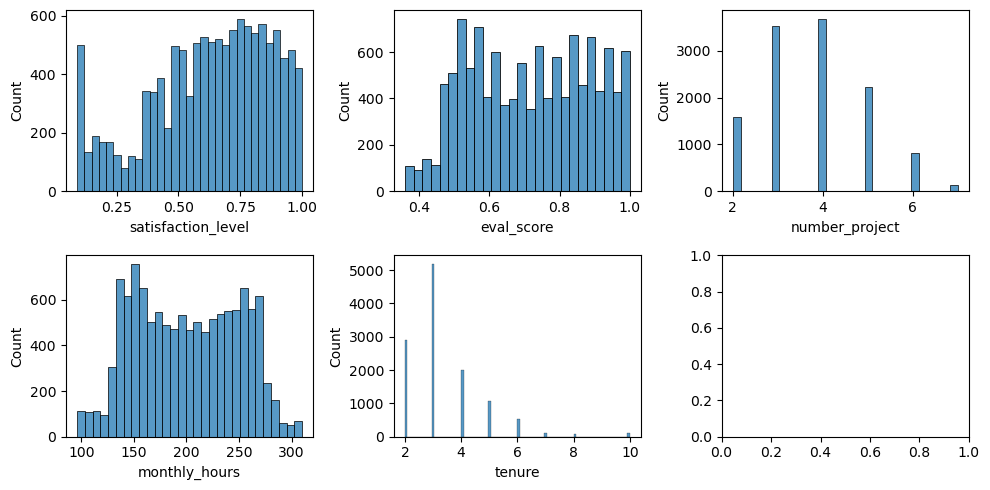

In [65]:
fig, axes = plt.subplots(2, 3, figsize = (10,5))

sns.histplot(data = df1, x = 'satisfaction_level', ax = axes[0,0])

sns.histplot(data = df1, x = 'eval_score', ax = axes[0,1])

sns.histplot(data = df1, x = 'number_project', ax = axes[0,2])

sns.histplot(data = df1, x = 'monthly_hours', ax = axes[1,0])

sns.histplot(data = df1, x = 'tenure', ax = axes[1,1])

plt.tight_layout()

plt.show()

In [66]:
df2 = df1.groupby(['left']).mean(numeric_only = True).reset_index()

In [67]:
df2.head()

,left,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,recent_promotion
0,0,0.667365,0.715667,3.786800,198.94270,3.262000,0.174500,0.019500
1,1,0.440271,0.721783,3.883476,208.16223,3.881467,0.052737,0.004018


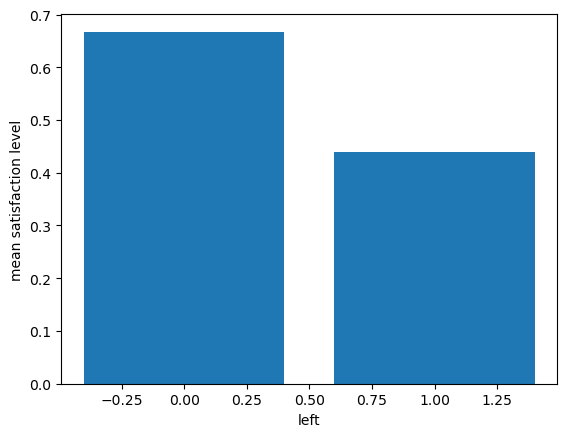

In [68]:
# Barplot of satisfaction level by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'satisfaction_level')
plt.xlabel('left')
plt.ylabel('mean satisfaction level')
plt.show()

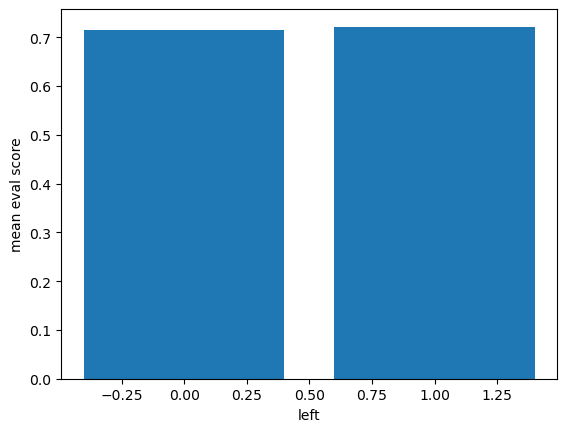

In [69]:
# Barplot of recent evaluation score by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'eval_score')
plt.xlabel('left')
plt.ylabel('mean eval score')
plt.show()

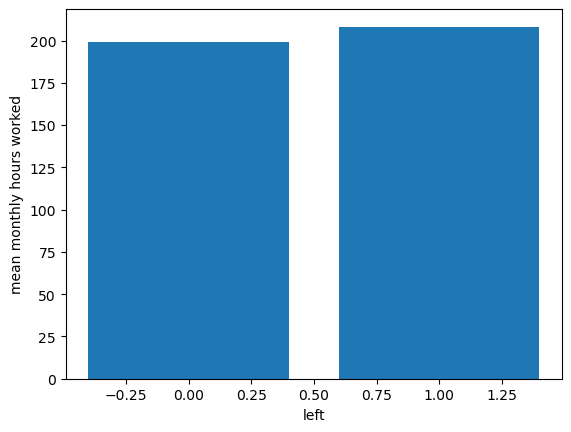

In [70]:
# Barplot of average monthly hours worked by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'monthly_hours')
plt.xlabel('left')
plt.ylabel('mean monthly hours worked')
plt.show()


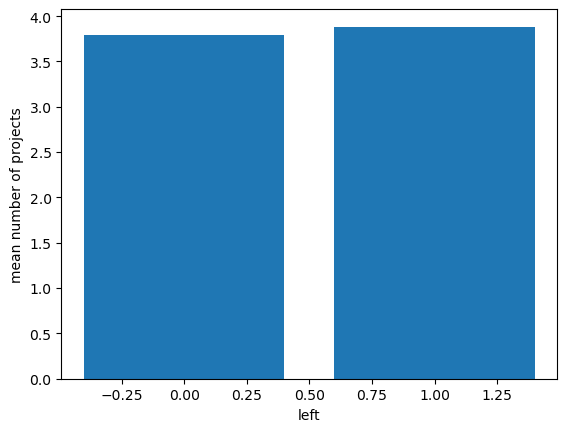

In [71]:
# Barplot of mean number of projects by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'number_project')
plt.xlabel('left')
plt.ylabel('mean number of projects')
plt.show()


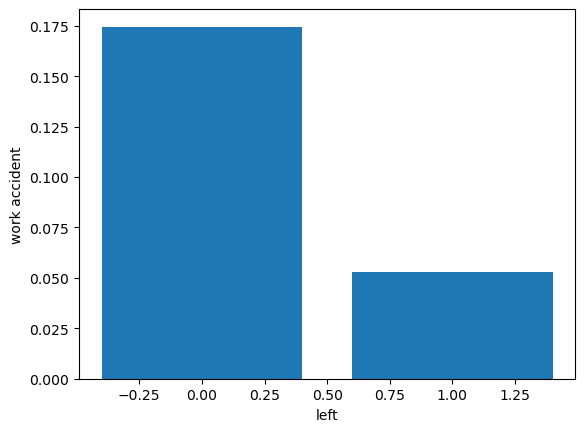

In [72]:
# Barplot of percentage of people who had a work accident by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'work_accident')
plt.xlabel('left')
plt.ylabel('work accident')
plt.show()

Text(0, 0.5, 'proportion of people who had accident')

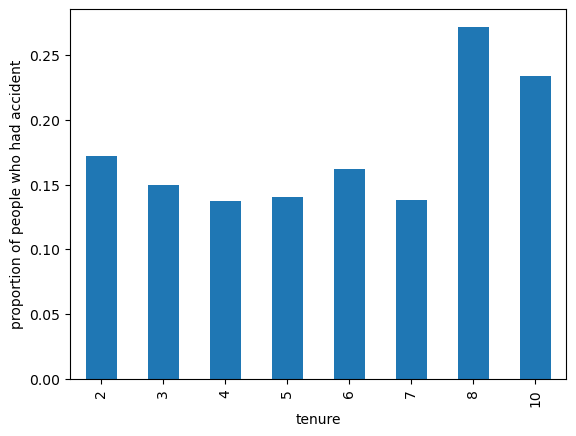

In [73]:
# Barplot of the proportion of people who had a work accident by tenure
df7 = pd.DataFrame(df1[['tenure', 'work_accident']].value_counts()).reset_index()


df7 = df7.pivot(index='tenure', columns='work_accident', values= 0 ).sort_values(by = 'tenure')
df7['proportion'] = df7[1]/(df7[1] + df7[0])

df7.drop([0,1], axis = 1)

df7['proportion'].plot(kind = 'bar')

plt.ylabel('proportion of people who had accident')


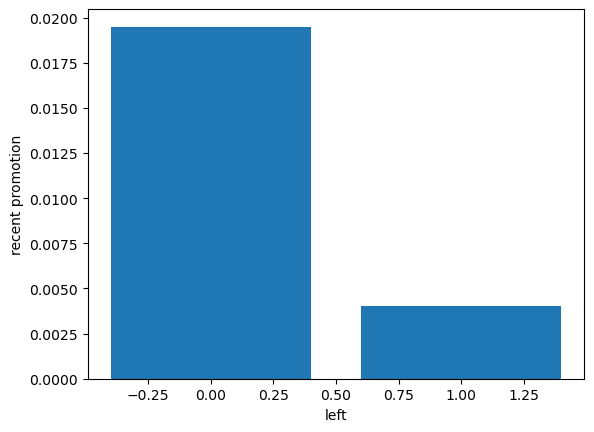

In [74]:
# Barplot of whether or not the employee had a recent promotion by whether or not the employee left
plt.bar(data = df2, x = 'left', height = 'recent_promotion')
plt.xlabel('left')
plt.ylabel('recent promotion')
plt.show()

In [75]:
# Salary groups (low, medium, or high) for employees who left (1) and didn't leave (0)
df1[['salary', 'left']].value_counts()

salary  left
low     0       4566
medium  0       4492
low     1       1174
high    0        942
medium  1        769
high    1         48
dtype: int64

In [76]:
# Creating a dataframe to be used in a heatmap
df3 = df1.value_counts(['salary', 'left']).reset_index()
df3 = pd.DataFrame(df3)
df3['salary'] = pd.Categorical(df3['salary'], categories = ['low', 'medium', 'high'], ordered = True)

df3['salary'].cat.codes

df3['salary1'] = df3['salary'].cat.codes


df4 = df3.pivot(index='salary', columns='left', values= 0 )
df4

left,0,1
salary,,
low,4566,1174
medium,4492,769
high,942,48


In [77]:
df3

,salary,left,0,salary1
0,low,0,4566,0
1,medium,0,4492,1
2,low,1,1174,0
3,high,0,942,2
4,medium,1,769,1
5,high,1,48,2


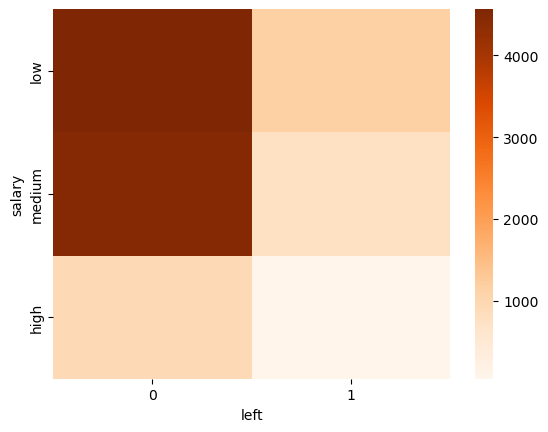

In [78]:
# Heatmap of quantity of people who left by salary level
ax = sns.heatmap(df4, cmap = 'Oranges')
colorbar = ax.collections[0].colorbar

<Axes: xlabel='salary'>

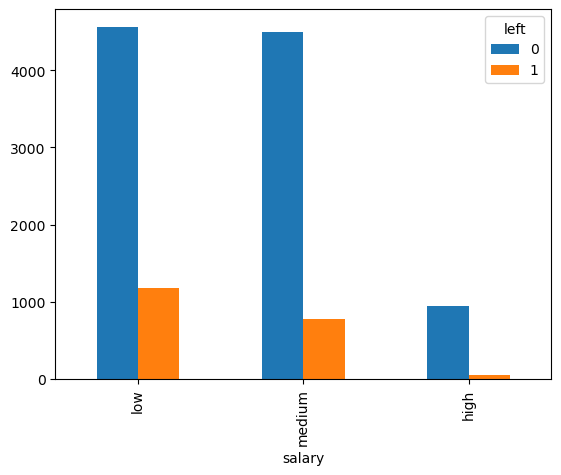

In [79]:
# Whether or not an employee left by salary level
df4.plot(kind="bar")

Text(0, 0.5, 'proportion of people who left')

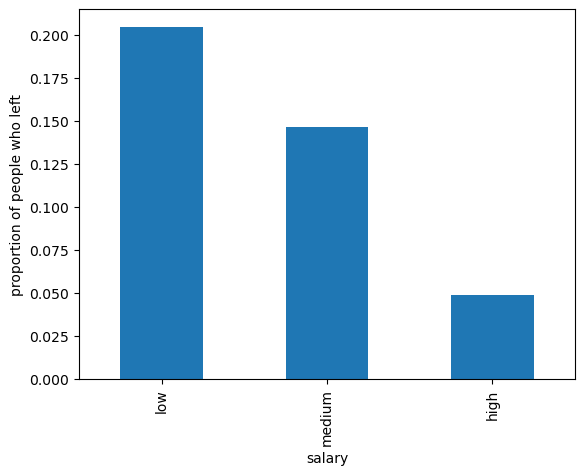

In [80]:
# Barplot of the proportion of people who left vs. stayed by salary level
df4['proportion'] = df4[1]/(df4[1] + df4[0])

df4.drop([0,1], axis = 1)

df4['proportion'].plot(kind = 'bar')

plt.ylabel('proportion of people who left')

<Axes: xlabel='dept'>

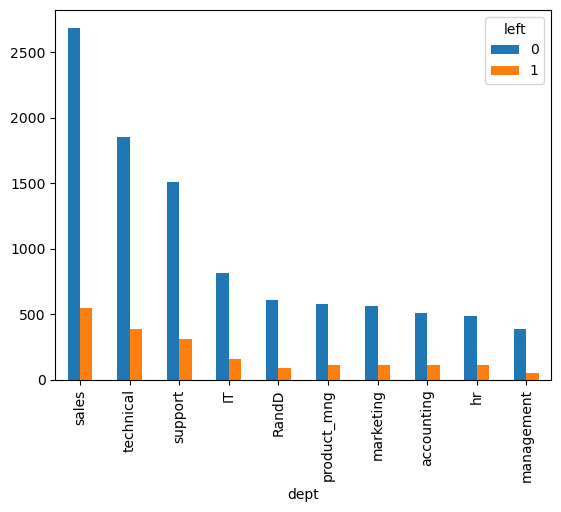

In [81]:
# Quantity of people who left vs. didn't leave by department 
df5 = pd.DataFrame(df1[['dept', 'left']].value_counts()).reset_index()


df5 = df5.pivot(index='dept', columns='left', values= 0 ).sort_values(by = 0, ascending = False)

df5.plot(kind = 'bar')

Text(0, 0.5, 'proportion of people who left')

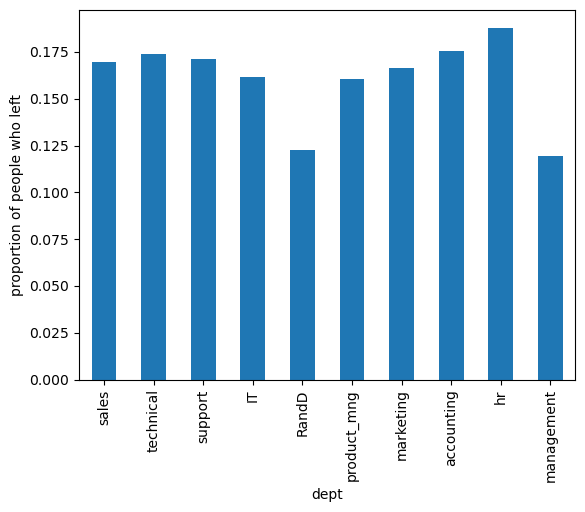

In [82]:
# Proportion of people who left by department
df5['proportion'] = df5[1]/(df5[1] + df5[0])

df5.drop([0,1], axis = 1)

df5['proportion'].plot(kind = 'bar')

plt.ylabel('proportion of people who left')

<Axes: xlabel='tenure'>

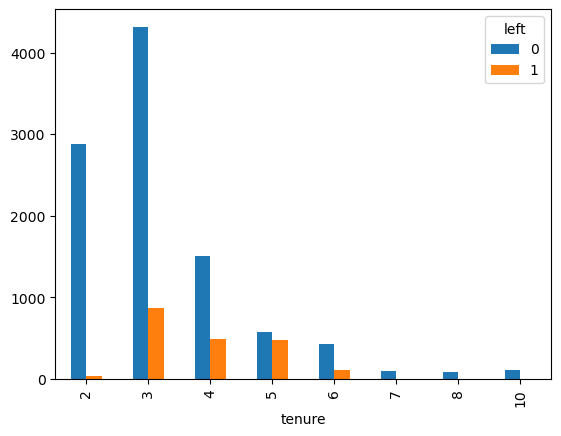

In [83]:
# Barplot of people who left vs. didn't leave by tenure
df6 = pd.DataFrame(df1[['tenure', 'left']].value_counts()).reset_index()


df6 = df6.pivot(index='tenure', columns='left', values= 0 ).sort_values(by = 'tenure')

df6.plot(kind = 'bar')

Text(0, 0.5, 'proportion of people who left')

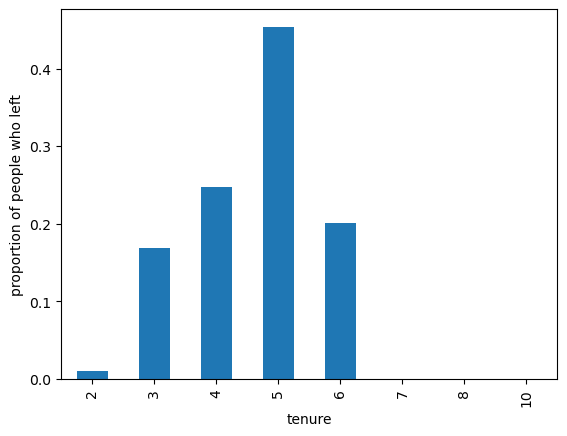

In [84]:
# Proportion of people who left by tenure
df6['proportion'] = df6[1]/(df6[1] + df6[0])

df6.drop([0,1], axis = 1)

df6['proportion'].plot(kind = 'bar')

plt.ylabel('proportion of people who left')

## 3. Model building and evaluation

#### Logistic Regression Model

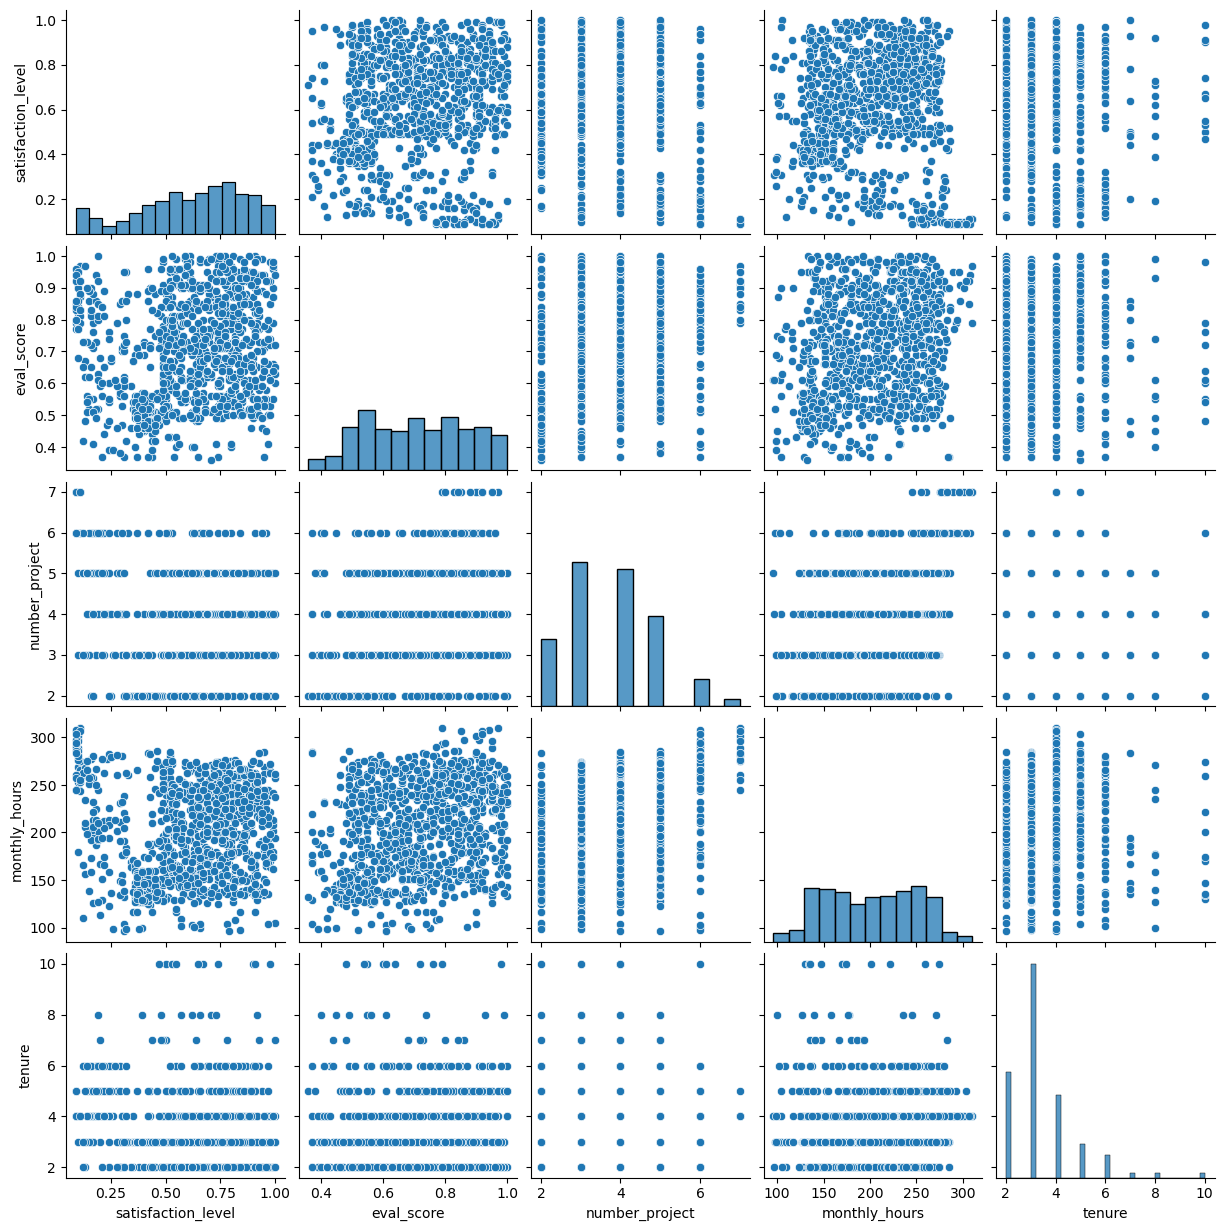

In [85]:
# Checking no multicollinearity assumption

df8 = df1.sample(1000, random_state = 0)
sns.pairplot(df8[['satisfaction_level', 'eval_score', 'number_project', 'monthly_hours', 'tenure']])

In [87]:
# Preparing data for modeling

model_df = df1.copy()

model_df['salary'] = pd.Categorical(model_df['salary'], categories = ['low', 'medium', 'high'], 
                               ordered = True)

model_df['salary1'] = model_df['salary'].cat.codes

model_df = model_df.drop(['salary'], axis = 1)

model_df = pd.get_dummies(model_df, drop_first = True, columns = ['dept'])

In [88]:
# Ensuring data is ready for modeling
model_df.head()

,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,left,recent_promotion,salary1,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [89]:
# Ensuring modeling data is of the correct type
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11990
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   satisfaction_level  11991 non-null  float64
 1   eval_score          11991 non-null  float64
 2   number_project      11991 non-null  int64  
 3   monthly_hours       11991 non-null  int64  
 4   tenure              11991 non-null  int64  
 5   work_accident       11991 non-null  int64  
 6   left                11991 non-null  int64  
 7   recent_promotion    11991 non-null  int64  
 8   salary1             11991 non-null  int8   
 9   dept_RandD          11991 non-null  uint8  
 10  dept_accounting     11991 non-null  uint8  
 11  dept_hr             11991 non-null  uint8  
 12  dept_management     11991 non-null  uint8  
 13  dept_marketing      11991 non-null  uint8  
 14  dept_product_mng    11991 non-null  uint8  
 15  dept_sales          11991 non-null  uint8  
 16  dept

In [170]:
# Splitting the data into features and target, and then into training and test sets
X = model_df.drop(['left'], axis = 1)
y = model_df['left']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 0)

In [92]:
# Creating validation sets

X_tr, X_val, y_tr, y_val = train_test_split(X_train, 
                                            y_train, 
                                            test_size = 0.25, 
                                            stratify = y_train, 
                                            random_state = 0)

In [171]:
# Instantiating the model and fitting it to the data
clf = LogisticRegression(solver = 'liblinear')

clf.fit(X_tr, y_tr)

LogisticRegression(solver='liblinear')

In [172]:
# Creating a table with the results of the logistic regression coefficients
lr_results = pd.DataFrame(clf.coef_, columns = X.columns)
lr_results

,satisfaction_level,eval_score,number_project,monthly_hours,tenure,work_accident,recent_promotion,salary1,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,-3.93651,0.398696,-0.264923,0.003874,0.319423,-1.605401,-0.995711,-0.583755,-0.554087,-0.026225,-0.013909,-0.380046,0.119746,-0.09844,0.009412,-0.066165,0.021552


In [96]:
# Evaluating model performance

y_pred = clf.predict(X_val)

print('Accuracy: ' + str(accuracy_score(y_val, y_pred)))
print('Precision: ' + str(precision_score(y_val, y_pred)))
print('Recall: ' + str(recall_score(y_val, y_pred)))
print('F1 score: ' + str(f1_score(y_val, y_pred)))

Accuracy: 0.8286071726438698
Precision: 0.45751633986928103
Recall: 0.17587939698492464
F1 score: 0.2540834845735027


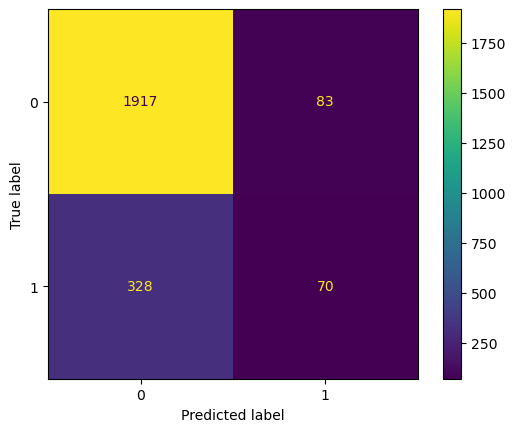

In [97]:
# Counfusion matrix to visualize model performance on validation data

cm = confusion_matrix(y_val, y_pred, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

disp.plot()

#### Logistic regression only using the most predictive features 

In [98]:
# Splitting the data into feature and target dataframes and training and test datasets
X = model_df[['satisfaction_level', 'eval_score', 'tenure', 'work_accident', 'recent_promotion', 'salary1']]
y = model_df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 0)

In [99]:
# Instantiating the model and fitting it to the data
clf = LogisticRegression()

clf.fit(X_train, y_train)

LogisticRegression()

In [100]:
# Evaluating the model
y_pred = clf.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.8361817423926636
Precision: 0.5123152709359606
Recall: 0.2613065326633166
F1 score: 0.34608985024958405


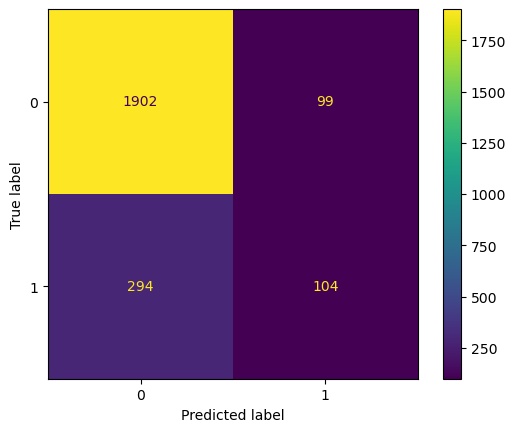

In [101]:
# Creating a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

disp.plot()

*This model performed marginally better without the department predictor.* 

Accuracy: 0.8261775739891621
Precision: 0.44571428571428573
Recall: 0.19597989949748743
F1 score: 0.27225130890052357


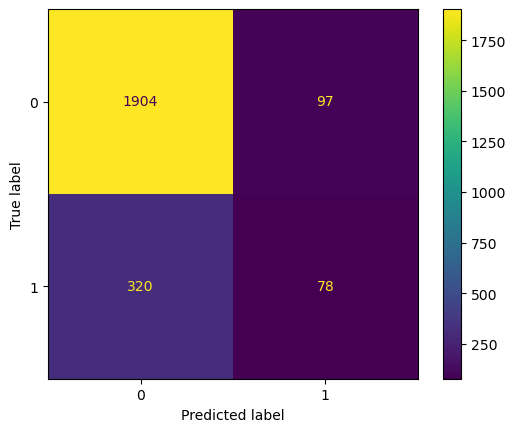

In [103]:
# Trying the original model with scaled data
X = model_df.drop(['left'], axis = 1)
y = model_df['left']

# Standardizing data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, stratify = y, random_state = 0)

clf = LogisticRegression()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

disp.plot()

Accuracy: 0.834931221342226
Precision: 0.5048543689320388
Recall: 0.2613065326633166
F1 score: 0.3443708609271523


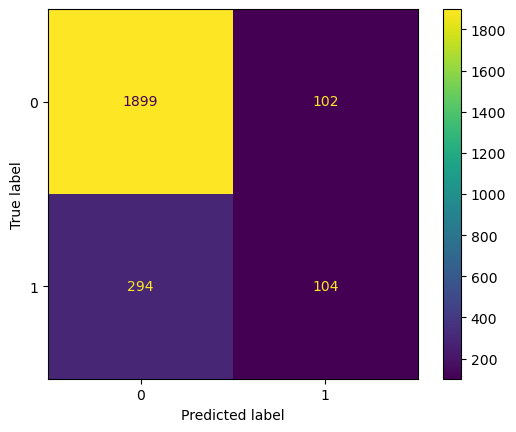

In [104]:
# Trying the model with scaled data and without department

X = model_df[['satisfaction_level', 'eval_score', 'tenure', 'work_accident', 'recent_promotion', 'salary1']]
y = model_df['left']

# Standardizing data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, stratify = y, random_state = 0)

clf = LogisticRegression()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

disp.plot()

*The model using scaled data and without deptartment is best logistic regression model.* 

In [106]:
#pip install --upgrade scikit-learn # RocCurveDisplay from_predictions is only in the new sklearn

0.6051660099598442


<function matplotlib.pyplot.show(close=None, block=None)>

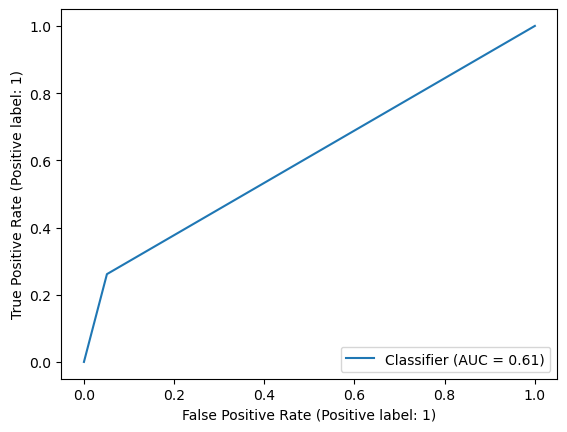

In [107]:
# ROC and AUC score

import sklearn.metrics as metrics

print(metrics.roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)

plt.show

#### Random Forest model 

In [139]:
# Creating training, test, and validation datasets
X = model_df.drop(['left'], axis = 1)
y = model_df['left']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 0)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, 
                                            y_train, 
                                            test_size = 0.25, 
                                            stratify = y_train, 
                                            random_state = 0)

In [114]:
# Creating random forest model

cv_params = {'max_depth' : [50,60,70],
            'max_samples' : [0.5,0.75,0.9],
            'max_features' : [8,12,16], 
            'min_samples_leaf' : [5,10,20],
            'min_samples_split' : [.005, .001],
            'n_estimators' : [50, 100]}

scoring = ('recall', 'precision', 'accuracy', 'f1')

rf = RandomForestClassifier(random_state = 0)

rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'f1')

In [115]:
# Fitting the model
rf_cv.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [50, 60, 70], 'max_features': [8, 12, 16],
                         'max_samples': [0.5, 0.75, 0.9],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [0.005, 0.001],
                         'n_estimators': [50, 100]},
             refit='f1', scoring=('recall', 'precision', 'accuracy', 'f1'))

In [127]:
# Pickling the model so that it doesn't need to be re-run
path = ''

#with open(path + 'rf_cv.pickle', 'wb') as to_write:
    #pickle.dump(rf_cv, to_write)

In [128]:
#with open(path + 'rf_cv.pickle', 'rb') as to_read:
    #rf_cv = pickle.load(to_read)

{'max_depth': 50, 'max_features': 8, 'max_samples': 0.9, 'min_samples_leaf': 5, 'min_samples_split': 0.001, 'n_estimators': 100}
0.9456971715027516

Accuracy: 0.981651376146789
Precision: 0.9809782608695652
Recall: 0.907035175879397
F1 score: 0.9425587467362924


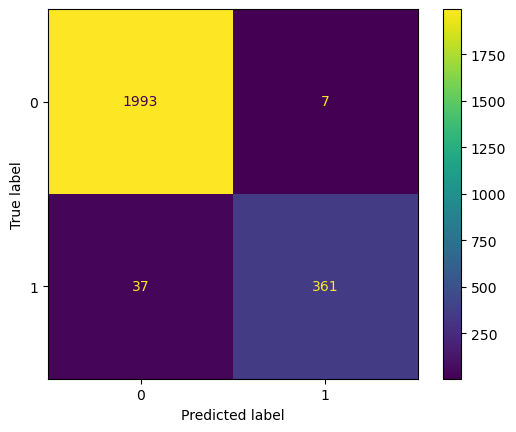

In [129]:
# Evaluating for retuning
y_pred = rf_cv.predict(X_val)


print(rf_cv.best_params_)
print(rf_cv.best_score_)
print()
print('Accuracy: ' + str(accuracy_score(y_val, y_pred)))
print('Precision: ' + str(precision_score(y_val, y_pred)))
print('Recall: ' + str(recall_score(y_val, y_pred)))
print('F1 score: ' + str(f1_score(y_val, y_pred)))

cm = confusion_matrix(y_val, y_pred, labels = rf_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_cv.classes_)

disp.plot()

In [130]:
# Tuning hyperparams
cv_params1 = {'max_depth' : [40, 50, 60],
            'max_samples' : [0.85,0.9,0.95],
            'max_features' : [7,8,9], 
            'min_samples_leaf' : [5,6,7],
            'min_samples_split' : [.002,.001, None],
            'n_estimators' : [100, 110, 120]}

rf_cv1 = GridSearchCV(rf, cv_params1, scoring = scoring, cv = 5, refit = 'f1')

In [135]:
# Fit model
rf_cv1.fit(X_tr, y_tr)

In [132]:
#with open(path + 'rf_cv1.pickle', 'wb') as to_write:
    #pickle.dump(rf_cv1, to_write)
    


In [133]:
#with open(path + 'rf_cv1.pickle', 'rb') as to_read:
    #rf_cv1 = pickle.load(to_read)

{'max_depth': 40, 'max_features': 8, 'max_samples': 0.95, 'min_samples_leaf': 5, 'min_samples_split': 0.001, 'n_estimators': 110}
0.9469790400619752

Accuracy: 0.982068390325271
Precision: 0.9836512261580381
Recall: 0.907035175879397
F1 score: 0.9437908496732026


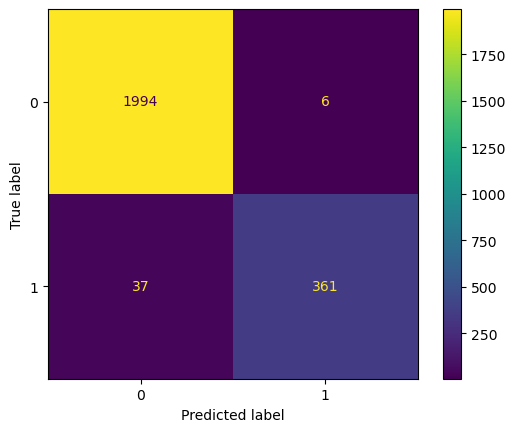

In [134]:
# Evaluate
y_pred = rf_cv1.predict(X_val)


print(rf_cv1.best_params_)
print(rf_cv1.best_score_)
print()
print('Accuracy: ' + str(accuracy_score(y_val, y_pred)))
print('Precision: ' + str(precision_score(y_val, y_pred)))
print('Recall: ' + str(recall_score(y_val, y_pred)))
print('F1 score: ' + str(f1_score(y_val, y_pred)))

cm = confusion_matrix(y_val, y_pred, labels = rf_cv1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_cv1.classes_)

disp.plot()

In [136]:
# Fitting a random forest model with only the best hyperparameter values
rf_best = RandomForestClassifier(max_depth = 40, 
                                 max_features = 8, 
                                 max_samples = 0.95, 
                                 min_samples_leaf = 5,
                                 min_samples_split = 0.001,
                                 n_estimators = 110,
                                 random_state = 0)

In [137]:
rf_best.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=40, max_features=8, max_samples=0.95,
                       min_samples_leaf=5, min_samples_split=0.001,
                       n_estimators=110, random_state=0)

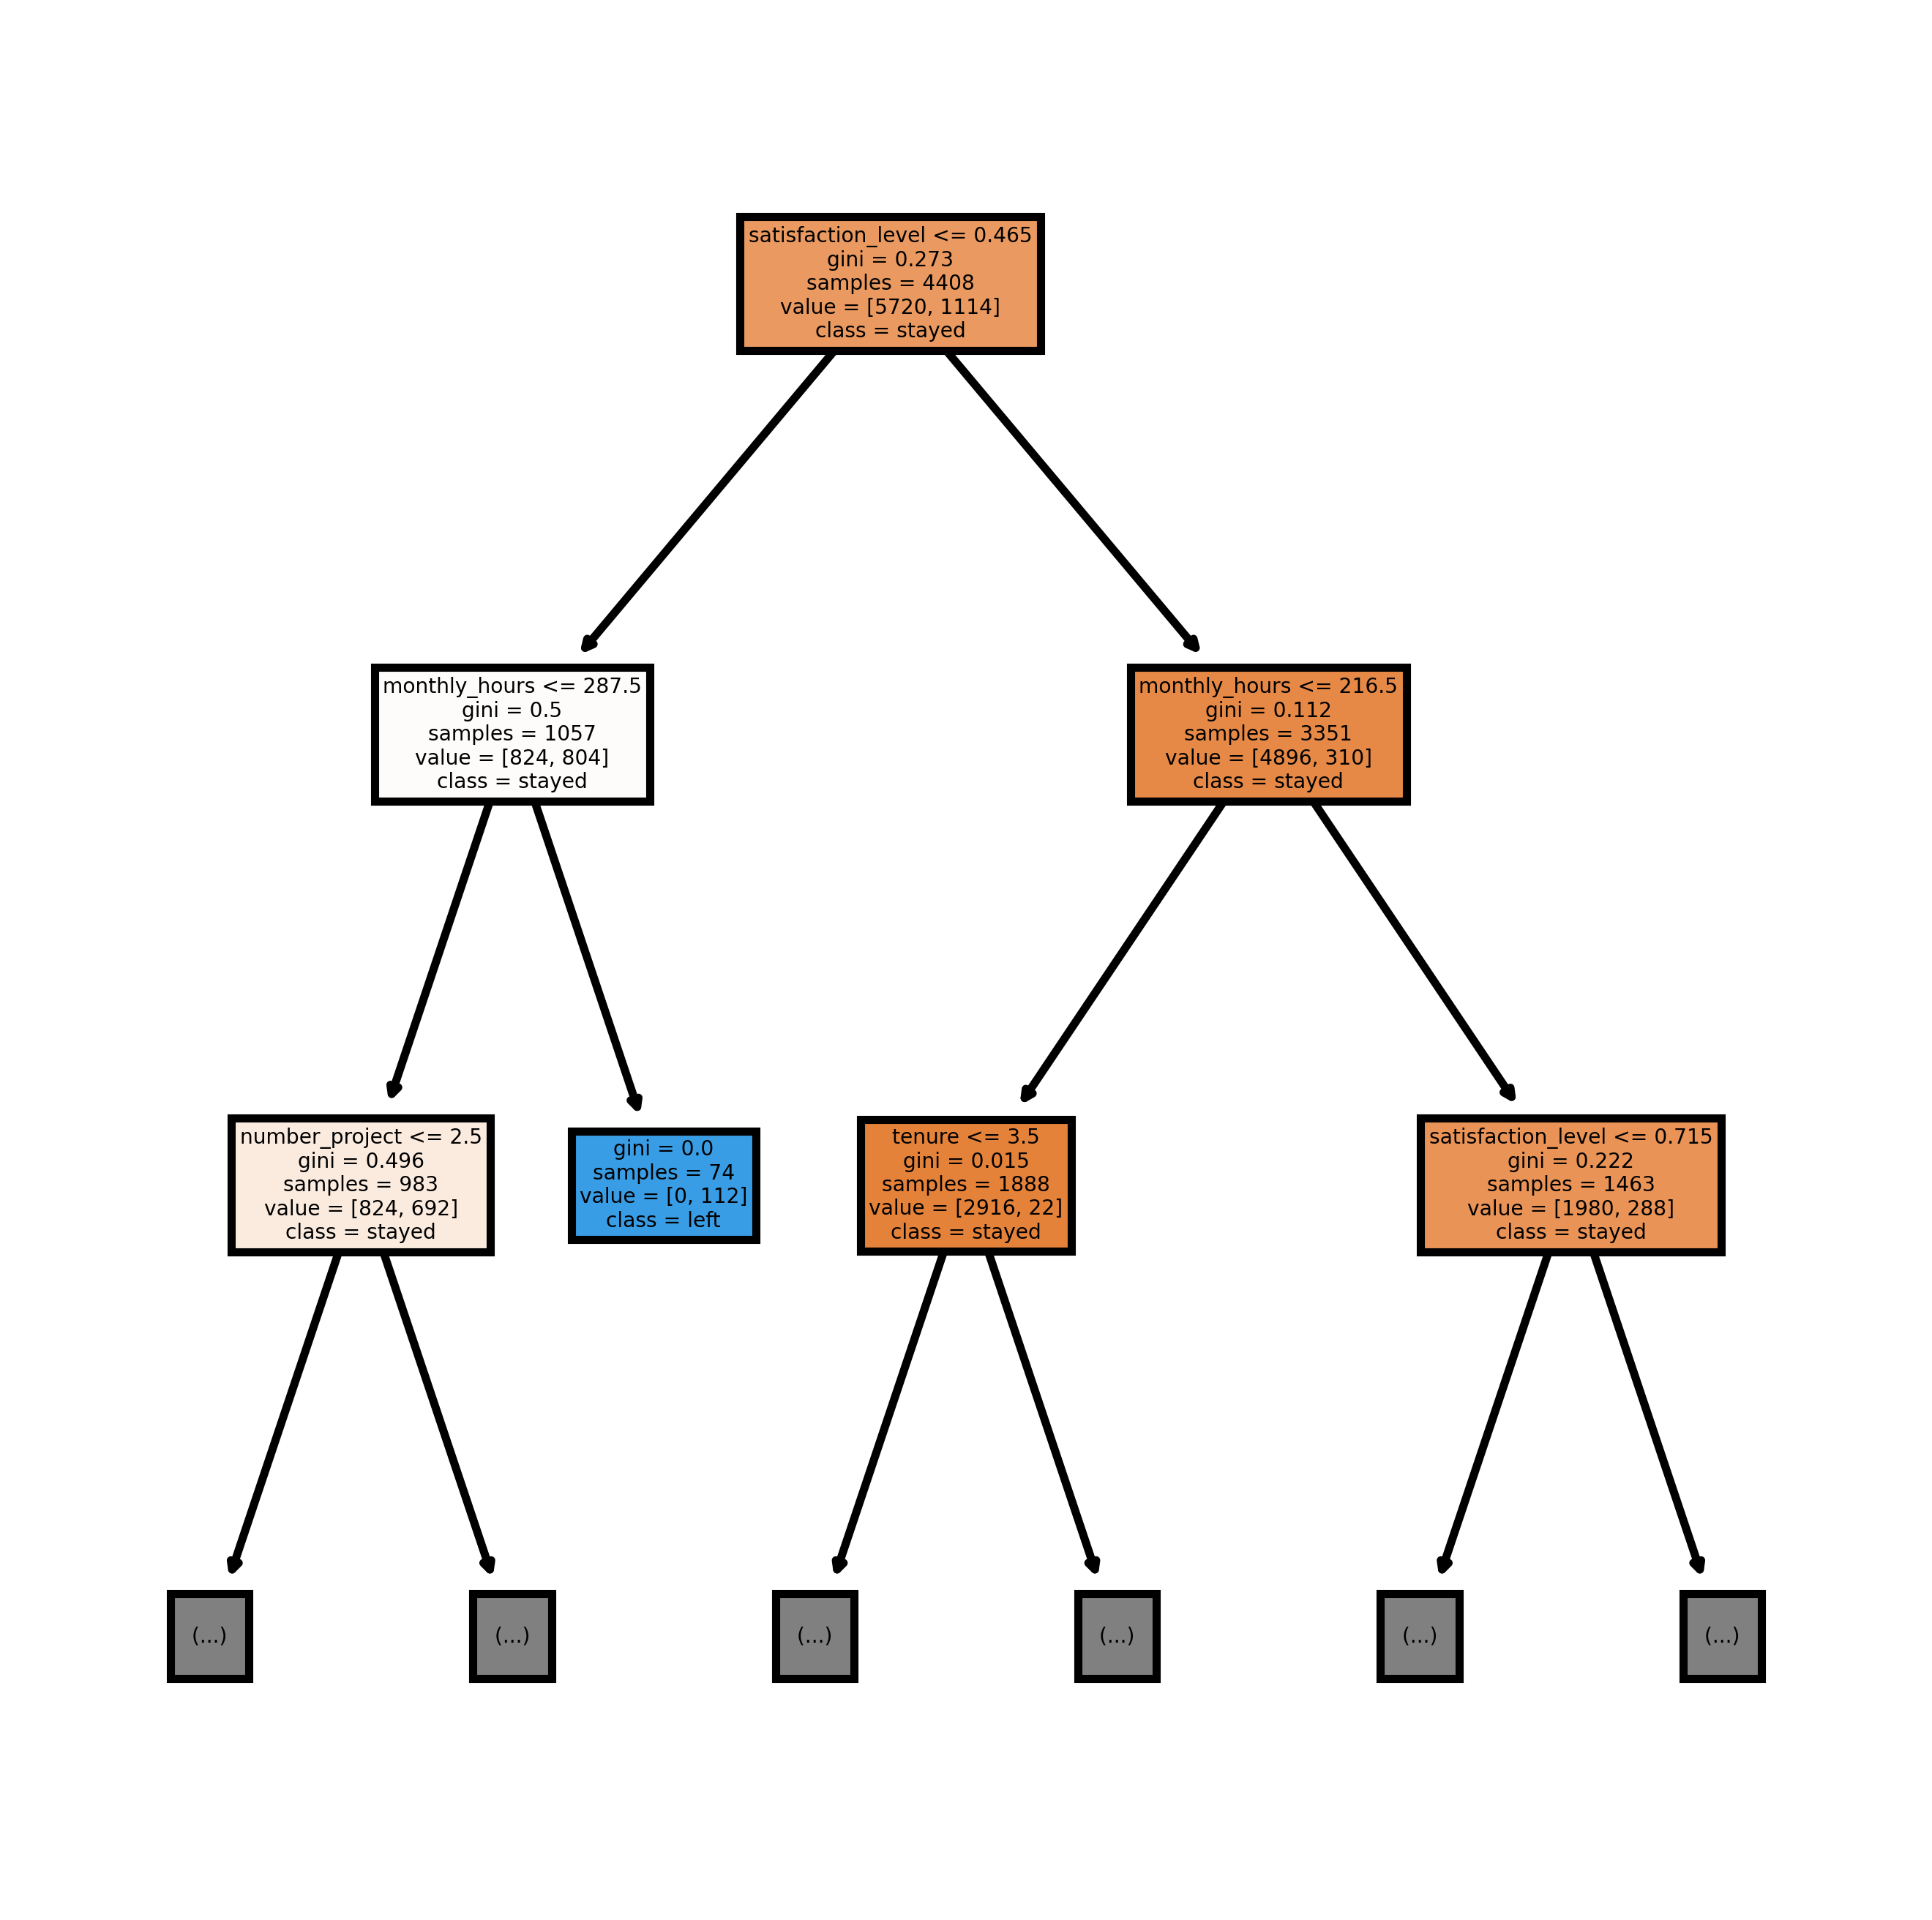

In [146]:
# Viewing one of the decision trees used in the random forest model
from sklearn import tree


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_best.estimators_[4], max_depth = 2,
               feature_names = list(X.columns), 
               class_names= ['stayed', 'left'],
               filled = True)

plt.show()

#### Graident Boosting model

In [151]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)
# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth' : [8, 10, 12], 'min_child_weight' : [1, 2, 3], 
             'learning_rate' : [0.1, 0.2, 0.3],
            'n_estimators' : [40,50,60]}

# 3. Define scoring metrics to capture
scoring = ['precision', 'recall', 'accuracy', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

In [152]:
# Fit the model to the data
xgb_cv.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [8, 10, 12],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [40, 50, 60]},
             refit='f1', scoring=['precision', 'recall', 'accuracy', 'f1'])

In [153]:
#with open(path + 'xgb_cv.pickle', 'wb') as to_write:
    #pickle.dump(xgb_cv, to_write)

In [154]:
# Opening the pickled model   
#with open(path + 'xgb_cv.pickle', 'rb') as to_read:
    #xgb_cv = pickle.load(to_read)

{'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 40}
0.9518896812772752

Accuracy: 0.9833194328607172
Precision: 0.9890710382513661
Recall: 0.9095477386934674
F1 score: 0.9476439790575917


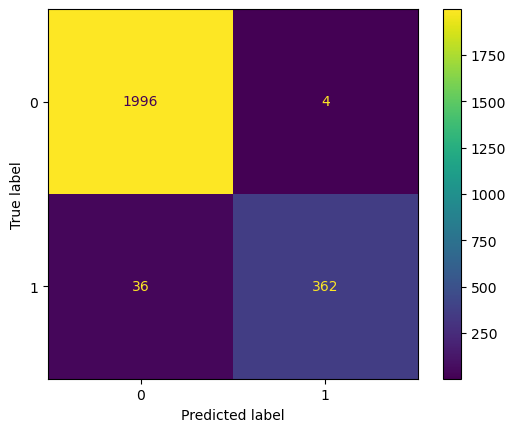

In [155]:
# Evaluating the XGBoost model
y_pred = xgb_cv.predict(X_val)


print(xgb_cv.best_params_)
print(xgb_cv.best_score_)
print()
print('Accuracy: ' + str(accuracy_score(y_val, y_pred)))
print('Precision: ' + str(precision_score(y_val, y_pred)))
print('Recall: ' + str(recall_score(y_val, y_pred)))
print('F1 score: ' + str(f1_score(y_val, y_pred)))

cm = confusion_matrix(y_val, y_pred, labels = xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_cv.classes_)

disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

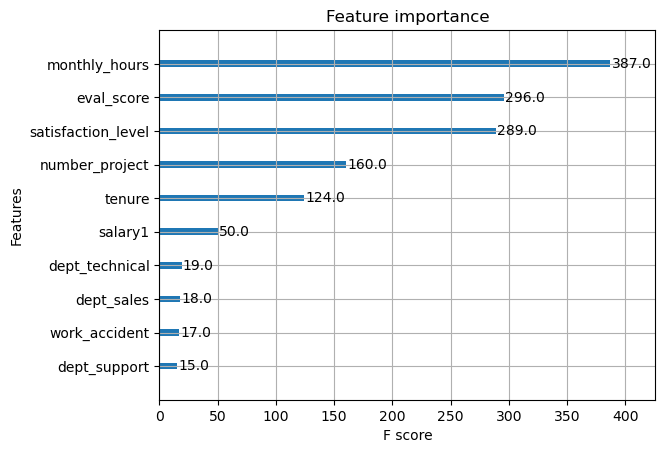

In [156]:
# Plot showing the most predictive features
plot_importance(xgb_cv.best_estimator_, max_num_features = 10)

In [157]:
# Tuned XGBoost 
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)
# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth' : [7,8,9], 'min_child_weight' : [1], 
             'learning_rate' : [0.2],
            'n_estimators' : [35,40,45]}

xgb_cv1 = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

In [158]:
# Fitting the tuned model
xgb_cv1.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [7, 8, 9],
                         'min_child_weight': [1],
                         'n_estimators': [35, 40, 45]},
             refit='f1', scoring=['precision', 'recall', 'accuracy', 'f1'])

In [159]:
#with open(path + 'xgb_cv1.pickle', 'wb') as to_write:
    #pickle.dump(xgb_cv1, to_write)

In [160]:
 #with open(path + 'xgb_cv1.pickle', 'rb') as to_read:
    #xgb_cv1 = pickle.load(to_read)

{'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 35}
0.9531745280453234

Accuracy: 0.9837364470391994
Precision: 0.989100817438692
Recall: 0.9120603015075377
F1 score: 0.9490196078431372


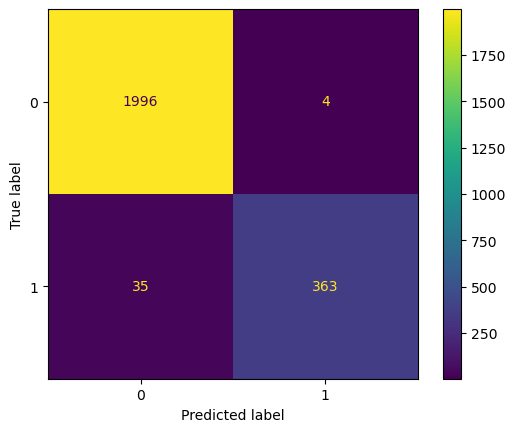

In [161]:
# Evaluating the tuned model
y_pred = xgb_cv1.predict(X_val)


print(xgb_cv1.best_params_)
print(xgb_cv1.best_score_)
print()
print('Accuracy: ' + str(accuracy_score(y_val, y_pred)))
print('Precision: ' + str(precision_score(y_val, y_pred)))
print('Recall: ' + str(recall_score(y_val, y_pred)))
print('F1 score: ' + str(f1_score(y_val, y_pred)))

cm = confusion_matrix(y_val, y_pred, labels = xgb_cv1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_cv1.classes_)

disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

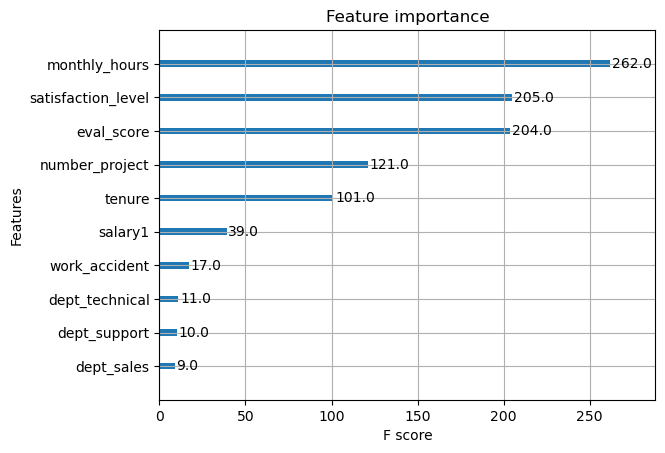

In [162]:
# Showing the most important features in the tuned model
plot_importance(xgb_cv1.best_estimator_, max_num_features = 10)

#### Final models trained on all training data (training and validation data)

In [163]:
# Best Random Forest
rf_best = RandomForestClassifier(max_depth = 40, 
                                 max_features = 8, 
                                 max_samples = 0.95, 
                                 min_samples_leaf = 5,
                                 min_samples_split = 0.001,
                                 n_estimators = 110,
                                 random_state = 0)

rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features=8, max_samples=0.95,
                       min_samples_leaf=5, min_samples_split=0.001,
                       n_estimators=110, random_state=0)

Accuracy: 0.9808253438932889
Precision: 0.9835164835164835
Recall: 0.8994974874371859
F1 score: 0.9396325459317584


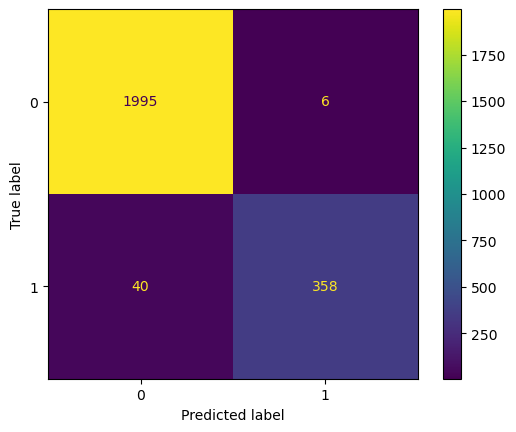

In [164]:
# Random forest test with unseen test data (for fun)
y_pred = rf_best.predict(X_test)


print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels = rf_best.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_best.classes_)

disp.plot()

In [165]:
# Best XGBoost model
xgb_best = XGBClassifier(objective = 'binary:logistic',
                         learning_rate = 0.2, max_depth = 7, min_child_weight = 1,
                         n_estimators = 35, random_state = 0)

xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=35, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

Accuracy: 0.9845769070446019
Precision: 0.989159891598916
Recall: 0.9170854271356784
F1 score: 0.9517601043024773


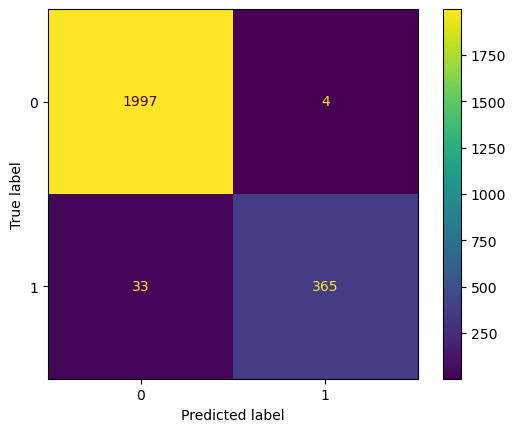

In [166]:
# XGBoost (Champion model) test with test data (to evaluate future performance)
y_pred = xgb_best.predict(X_test)


print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 score: ' + str(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels = xgb_best.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_best.classes_)

disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

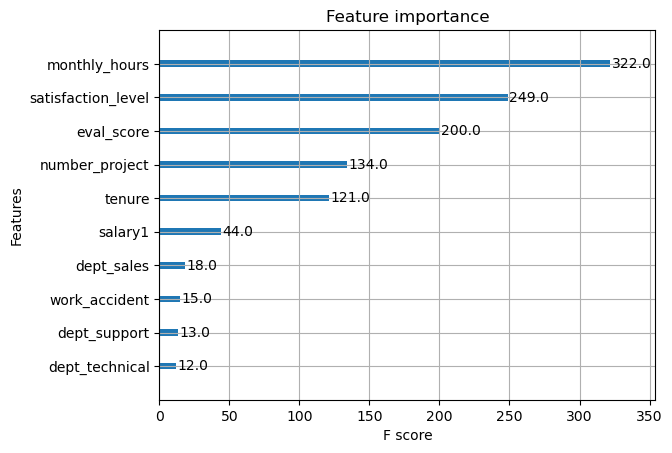

In [167]:
# Plot importance for champion model
plot_importance(xgb_best, max_num_features = 10)